# Water Network Neo4j Exploration

Interactive notebook to explore Neo4j fundamentals with water network data.

Based on `docs/02-neo4j-fundamentals.md`

In [1]:
# Required Modules

import sys
import os
import logging
import platform
from datetime import date, datetime

from dotenv import load_dotenv

from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

print(f"  System: {sys.platform}")
print(f"  Platform: {platform.platform()}")
print(f"  Python version: {platform.python_version()}")
print(f"  System Execution (Python) path: {'/'.join(sys.executable.strip('/').split('/')[-3:])}")
print(f"  Last update: {date.today().strftime('%Y-%m-%d')}")

  System: darwin
  Platform: macOS-15.6-arm64-arm-64bit
  Python version: 3.10.6
  System Execution (Python) path: .venv/bin/python
  Last update: 2025-08-14


In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## 1. Database Connection

Update the connection parameters below based on your Neo4j setup:

In [ ]:
# Create connection
driver = GraphDatabase.driver(uri= os.environ.get("URI"),
                              auth=(os.environ.get("USER"),
                                    os.environ.get("PASSWORD")
                                    )
                                )

# Test connection
with driver.session() as session:
    result = session.run("RETURN 'Connection successful!' AS message")
    print(result.single()["message"])

Connection successful!


## 2. Clear Database and Create Constraints

In [3]:
# Clear existing data
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")
    print("Database cleared.")

Database cleared.


In [4]:
# Create constraints
constraints = [
    "CREATE CONSTRAINT FOR (v:Valve) REQUIRE v.id IS UNIQUE",
    "CREATE CONSTRAINT FOR (p:Pipe) REQUIRE p.id IS UNIQUE", 
    "CREATE CONSTRAINT FOR (j:Junction) REQUIRE j.id IS UNIQUE",
    "CREATE CONSTRAINT FOR (t:Tank) REQUIRE t.id IS UNIQUE",
    "CREATE CONSTRAINT FOR (pump:Pump) REQUIRE pump.id IS UNIQUE"
]

with driver.session() as session:
    for constraint in constraints:
        try:
            session.run(constraint)
            print(f"✓ Created: {constraint}")
        except Exception as e:
            print(f"⚠ Constraint may already exist: {constraint}")

✓ Created: CREATE CONSTRAINT FOR (v:Valve) REQUIRE v.id IS UNIQUE
✓ Created: CREATE CONSTRAINT FOR (p:Pipe) REQUIRE p.id IS UNIQUE
✓ Created: CREATE CONSTRAINT FOR (j:Junction) REQUIRE j.id IS UNIQUE
✓ Created: CREATE CONSTRAINT FOR (t:Tank) REQUIRE t.id IS UNIQUE
✓ Created: CREATE CONSTRAINT FOR (pump:Pump) REQUIRE pump.id IS UNIQUE


## 3. Create Water Network Components

In [5]:
# Create sample water network components
components = [
    # Tank
    """
    CREATE (t1:Tank {
        id: 'TNK001',
        capacity: 1000000,
        level: 850000,
        elevation: 120.0,
        location: 'Reservoir Hill'
    })
    """,
    
    # Junctions
    """
    CREATE (j1:Junction {
        id: 'JCT001', 
        elevation: 100.0, 
        location: 'North District'
    })
    """,
    """
    CREATE (j2:Junction {
        id: 'JCT002', 
        elevation: 95.0, 
        location: 'Central Plaza'
    })
    """,
    
    # Valves
    """
    CREATE (v1:Valve {
        id: 'VLV001',
        type: 'Gate Valve',
        diameter: 12,
        status: 'Open',
        installDate: date('2015-03-15')
    })
    """,
    """
    CREATE (v2:Valve {
        id: 'VLV002',
        type: 'Ball Valve',
        diameter: 8,
        status: 'Closed',
        installDate: date('2018-07-22')
    })
    """,
    
    # Pump
    """
    CREATE (pump1:Pump {
        id: 'PMP001',
        type: 'Centrifugal',
        capacity: 500,
        status: 'Running',
        power: 25.5
    })
    """,
    
    # Pipes
    """
    CREATE (p1:Pipe {
        id: 'PIP001',
        material: 'Cast Iron',
        diameter: 12,
        length: 500.0,
        installDate: date('2010-05-10')
    })
    """,
    """
    CREATE (p2:Pipe {
        id: 'PIP002',
        material: 'PVC',
        diameter: 8,
        length: 300.0,
        installDate: date('2020-01-15')
    })
    """
]

with driver.session() as session:
    for component in components:
        session.run(component)
    print("✓ All components created successfully!")

✓ All components created successfully!


## 4. Create Relationships

In [6]:
# Create relationships between components
relationships = [
    # Tank feeds Junction 1 through Pipe 1
    "MATCH (t:Tank {id: 'TNK001'}), (p:Pipe {id: 'PIP001'}) CREATE (t)-[:FEEDS]->(p)",
    "MATCH (p:Pipe {id: 'PIP001'}), (j:Junction {id: 'JCT001'}) CREATE (p)-[:CONNECTS_TO]->(j)",
    
    # Junction 1 connects to Valve 1
    "MATCH (j:Junction {id: 'JCT001'}), (v:Valve {id: 'VLV001'}) CREATE (j)-[:CONNECTS_TO]->(v)",
    
    # Valve 1 connects to Junction 2 through Pipe 2
    "MATCH (v:Valve {id: 'VLV001'}), (p:Pipe {id: 'PIP002'}) CREATE (v)-[:CONNECTS_TO]->(p)",
    "MATCH (p:Pipe {id: 'PIP002'}), (j:Junction {id: 'JCT002'}) CREATE (p)-[:CONNECTS_TO]->(j)",
    
    # Pump connected to Junction 2
    "MATCH (pump:Pump {id: 'PMP001'}), (j:Junction {id: 'JCT002'}) CREATE (pump)-[:CONNECTS_TO]->(j)",
    
    # Valve 2 also connected to Junction 2
    "MATCH (v:Valve {id: 'VLV002'}), (j:Junction {id: 'JCT002'}) CREATE (v)-[:CONNECTS_TO]->(j)"
]

with driver.session() as session:
    for rel in relationships:
        session.run(rel)
    print("✓ All relationships created successfully!")

✓ All relationships created successfully!


## 5. Basic Queries and Analysis

In [7]:
# Count components by type
with driver.session() as session:
    result = session.run("MATCH (n) RETURN labels(n) AS type, count(n) AS count")
    component_counts = [(record["type"][0], record["count"]) for record in result]
    
print("Component Counts:")
for component_type, count in component_counts:
    print(f"  {component_type}: {count}")

Component Counts:
  Tank: 1
  Junction: 2
  Valve: 2
  Pump: 1
  Pipe: 2


In [8]:
# Find all valves with their properties
with driver.session() as session:
    result = session.run("MATCH (v:Valve) RETURN v.id, v.type, v.status, v.diameter")
    valves_df = pd.DataFrame([dict(record) for record in result])
    
print("All Valves:")
display(valves_df)

All Valves:


,v.id,v.type,v.status,v.diameter
0,VLV001,Gate Valve,Open,12
1,VLV002,Ball Valve,Closed,8


In [9]:
# Find components connected to JCT002
with driver.session() as session:
    result = session.run("""
        MATCH (n)-[:CONNECTS_TO]-(j:Junction {id: 'JCT002'}) 
        RETURN n.id AS component_id, labels(n) AS type
    """)
    connected_df = pd.DataFrame([dict(record) for record in result])
    
print("Components connected to JCT002:")
display(connected_df)

Components connected to JCT002:


,component_id,type
0,VLV002,[Valve]
1,PMP001,[Pump]
2,PIP002,[Pipe]


In [10]:
# Find path from tank to junction
with driver.session() as session:
    result = session.run("""
        MATCH path = (t:Tank {id: 'TNK001'})-[*]-(j:Junction {id: 'JCT002'})
        RETURN [node in nodes(path) | node.id] AS path_components
        LIMIT 1
    """)
    
    for record in result:
        path = record["path_components"]
        print(f"Path from Tank to Junction: {' -> '.join(path)}")

Path from Tank to Junction: TNK001 -> PIP001 -> JCT001 -> VLV001 -> PIP002 -> JCT002


## 6. Visualization

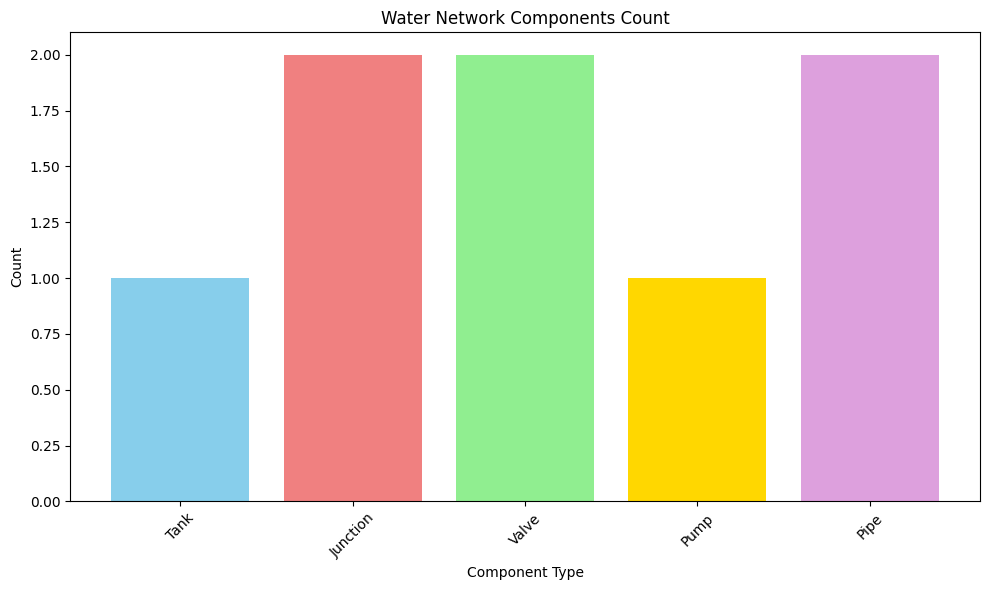

In [11]:
# Create a simple bar chart of component counts
types, counts = zip(*component_counts)

plt.figure(figsize=(10, 6))
plt.bar(types, counts, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
plt.title('Water Network Components Count')
plt.xlabel('Component Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Advanced Queries

In [13]:
# Find old infrastructure (installed before 2015)
# with driver.session() as session:
#     result = session.run("""
#         MATCH (n) 
#         WHERE exists(n.installDate) AND n.installDate < date('2015-01-01')
#         RETURN n.id, labels(n) AS type, n.installDate
#         ORDER BY n.installDate
#     """)
    
#     old_components = pd.DataFrame([dict(record) for record in result])
    
# print("Components installed before 2015:")
# display(old_components)

In [14]:
# Find critical components (high connectivity)
with driver.session() as session:
    result = session.run("""
        MATCH (n)-[r]-()
        RETURN n.id, labels(n) AS type, count(r) AS connections
        ORDER BY connections DESC
    """)
    
    connectivity_df = pd.DataFrame([dict(record) for record in result])
    
print("Components by connectivity:")
display(connectivity_df)

Components by connectivity:


,n.id,type,connections
0,JCT002,[Junction],3
1,PIP001,[Pipe],2
2,JCT001,[Junction],2
3,VLV001,[Valve],2
4,PIP002,[Pipe],2
5,TNK001,[Tank],1
6,VLV002,[Valve],1
7,PMP001,[Pump],1


## 8. Cleanup

In [ ]:
# Close the database connection
driver.close()
print("Database connection closed.")